In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
os.chdir('/content/drive/MyDrive/ClumateChangeData')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ClumateChangeData'

In [3]:
!ls

ArdsleyHackathon.ipynb	    CO2Data.csv		  TempData.csv
clean_data.csv		    GreenhouseGasses.csv
ClimateChangeProject.ipynb  Lstm.h5


In [3]:
import math
from pickle import dump, load

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam as Adam_new
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Flatten, Input

from scikeras.wrappers import KerasRegressor

from statsmodels.tsa.arima.model import ARIMA

import warnings

#Data Pre-Processing

In [4]:

# Read CO2 Emissions data
co2Data = pd.read_csv('CO2Data.csv')


# Read Greenhouse Gases data
ggData = pd.read_csv('GreenhouseGasses.csv')

# Read Surface Temperature Change data
tempData = pd.read_csv('TempData.csv')

# Now you can perform data preprocessing or further analysis on the loaded datasets

In [5]:
ggData.head()

,Year,CO2,CH4,N2O,CFC*,HCFCs,HFCs*,Total,Total.1,1990 = 1,change **
0,1979,1.027,0.406,0.104,0.154,0.008,0.001,1.700,382,0.785,NaN
1,1980,1.060,0.413,0.104,0.163,0.009,0.001,1.749,386,0.808,2.3
2,1981,1.079,0.420,0.107,0.172,0.009,0.001,1.788,388,0.825,1.8
3,1982,1.091,0.426,0.111,0.180,0.010,0.001,1.819,391,0.840,1.5
4,1983,1.117,0.429,0.113,0.190,0.011,0.001,1.861,394,0.859,1.9


In [6]:
tempData.head()

,Year,Value
0,1850,-0.22
1,1851,-0.19
2,1852,-0.38
3,1853,-0.18
4,1854,-0.22


In [7]:
tempData.tail()

,Year,Value
169,2019,1.05
170,2020,1.11
171,2021,0.79
172,2022,0.90
173,2023,1.00


In [8]:
co2Data.head()

,year,mean,unc
0,1959,315.98,0.12
1,1960,316.91,0.12
2,1961,317.64,0.12
3,1962,318.45,0.12
4,1963,318.99,0.12


In [9]:
ggData.describe()

,Year,CO2,CH4,N2O,CFC*,HCFCs,HFCs*,Total,Total.1,1990 = 1,change **
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,44.000000
mean,2000.911111,1.570311,0.475667,0.154622,0.251378,0.034044,0.014711,2.500689,445.244444,1.154733,1.677273
std,12.990945,0.343749,0.030469,0.032262,0.034604,0.017099,0.014129,0.452937,37.559744,0.209166,0.377177
min,1979.000000,1.027000,0.406000,0.104000,0.154000,0.008000,0.001000,1.700000,382.000000,0.785000,0.700000
25%,1990.000000,1.294000,0.459000,0.129000,0.246000,0.018000,0.003000,2.166000,417.000000,1.000000,1.500000
50%,2001.000000,1.538000,0.481000,0.153000,0.263000,0.034000,0.009000,2.494000,443.000000,1.152000,1.700000
75%,2012.000000,1.848000,0.494000,0.181000,0.276000,0.051000,0.025000,2.860000,475.000000,1.321000,1.825000
max,2021.000000,2.140000,0.526000,0.210000,0.282000,0.058000,0.044000,3.222000,508.000000,1.488000,2.700000


In [10]:
tempData.describe()

,Year,Value
count,174.000000,174.000000
mean,1936.500000,0.050115
std,50.373604,0.374245
min,1850.000000,-0.590000
25%,1893.250000,-0.210000
50%,1936.500000,-0.070000
75%,1979.750000,0.237500
max,2023.000000,1.140000


In [11]:
co2Data.describe()

,year,mean,unc
count,64.000000,64.000000,64.00
mean,1990.500000,358.295156,0.12
std,18.618987,30.583707,0.00
min,1959.000000,315.980000,0.12
25%,1974.750000,330.895000,0.12
50%,1990.500000,355.075000,0.12
75%,2006.250000,382.572500,0.12
max,2022.000000,418.560000,0.12


In [12]:
# Check for missing values in each dataset
co2_missing_values = co2Data.isnull().sum()
gg_missing_values = ggData.isnull().sum()
temp_missing_values = tempData.isnull().sum()

# Print the number of missing values in each dataset
print("CO2 Emissions - Missing Values:")
print(co2_missing_values)

print("\nGreenhouse Gases - Missing Values:")
print(gg_missing_values)

print("\nSurface Temperature Change - Missing Values:")
print(temp_missing_values)

CO2 Emissions - Missing Values:
year    0
mean    0
unc     0
dtype: int64

Greenhouse Gases - Missing Values:
Year         0
CO2          0
CH4          0
N2O          0
CFC*         0
HCFCs        0
HFCs*        0
Total        0
Total.1      0
1990 = 1     0
change **    1
dtype: int64

Surface Temperature Change - Missing Values:
Year     0
Value    0
dtype: int64


In [13]:
co2Data = co2Data.fillna(co2Data.mean())
ggData = ggData.fillna(ggData.mean())
tempData = tempData.fillna(tempData.mean())

In [14]:
# rename 'year' column in co2Data
co2Data.rename(columns={'year': 'Year'}, inplace=True)

# filter dataframes to include data from 1974 to 2021 only
ggData = ggData[(ggData['Year'] >= 1979) & (ggData['Year'] <= 2021)]
tempData = tempData[(tempData['Year'] >= 1979) & (tempData['Year'] <= 2021)]
co2Data = co2Data[(co2Data['Year'] >= 1979) & (co2Data['Year'] <= 2021)]

# merge the dataframes
df = pd.merge(ggData, tempData, on='Year')
df = pd.merge(df, co2Data, on='Year')

In [15]:
df.tail()

,Year,CO2,CH4,N2O,CFC*,HCFCs,HFCs*,Total,Total.1,1990 = 1,change **,Value,mean,unc
40,2019,2.079,0.516,0.202,0.250,0.057,0.039,3.144,500,1.452,1.8,1.05,411.66,0.12
41,2020,2.111,0.520,0.206,0.248,0.057,0.041,3.183,504,1.470,1.8,1.11,414.24,0.12
42,2020,2.111,0.520,0.206,0.248,0.057,0.041,3.183,504,1.470,1.8,1.11,414.24,0.12
43,2021,2.140,0.526,0.210,0.246,0.058,0.044,3.222,508,1.488,1.8,0.79,416.45,0.12
44,2021,2.140,0.526,0.210,0.246,0.058,0.044,3.222,508,1.488,1.8,0.79,416.45,0.12


In [16]:
df.drop_duplicates(subset='Year', inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df.tail()

,Year,CO2,CH4,N2O,CFC*,HCFCs,HFCs*,Total,Total.1,1990 = 1,change **,Value,mean,unc
38,2017,2.016,0.509,0.195,0.254,0.056,0.035,3.065,493,1.415,1.6,0.97,406.76,0.12
39,2018,2.047,0.512,0.199,0.253,0.057,0.037,3.104,497,1.433,1.8,0.90,408.72,0.12
40,2019,2.079,0.516,0.202,0.250,0.057,0.039,3.144,500,1.452,1.8,1.05,411.66,0.12
41,2020,2.111,0.520,0.206,0.248,0.057,0.041,3.183,504,1.470,1.8,1.11,414.24,0.12
42,2021,2.140,0.526,0.210,0.246,0.058,0.044,3.222,508,1.488,1.8,0.79,416.45,0.12


In [18]:
# Define a dictionary with old column names as keys and new column names as values
rename_dict = {
    'Year': 'Year',
    'CO2': 'CO2',
    'CH4': 'Methane',
    'N2O': 'Nitrous_Oxide',
    'CFC*': 'CFCs',
    'HCFCs': 'Hydrochlorofluorocarbons',
    'HFCs*': 'Hydrofluorocarbons',
    'Total': 'Total_Greenhouse_Gases',
    'Total.1': 'Total_Greenhouse_Gases_Scaled',
    '1990 = 1': '1990_Equals_1',
    'change **': 'Change',
    'Value': 'Surface_Temperature',
    'mean': 'CO2_Mean',
    'unc': 'CO2_Uncertainty'
}

# Rename the columns
df.rename(columns=rename_dict, inplace=True)
df = df.drop(columns=['CO2_Uncertainty'])

In [19]:
df.describe()

,Year,CO2,Methane,Nitrous_Oxide,CFCs,Hydrochlorofluorocarbons,Hydrofluorocarbons,Total_Greenhouse_Gases,Total_Greenhouse_Gases_Scaled,1990_Equals_1,Change,Surface_Temperature,CO2_Mean
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,2000.000000,1.544488,0.473465,0.152140,0.251581,0.032953,0.013419,2.468047,442.418605,1.139651,1.671564,0.559070,372.598605
std,12.556539,0.329271,0.029334,0.030793,0.035405,0.016699,0.013059,0.436300,35.969056,0.201470,0.380656,0.268397,23.407123
min,1979.000000,1.027000,0.406000,0.104000,0.154000,0.008000,0.001000,1.700000,382.000000,0.785000,0.700000,0.100000,336.840000
25%,1989.500000,1.284000,0.457000,0.127500,0.247000,0.017500,0.002500,2.148000,415.500000,0.992000,1.500000,0.370000,353.825000
50%,2000.000000,1.515000,0.481000,0.151000,0.263000,0.032000,0.008000,2.468000,441.000000,1.140000,1.677273,0.560000,369.710000
75%,2010.500000,1.807000,0.491500,0.176000,0.277000,0.049000,0.022000,2.811000,470.500000,1.297500,1.850000,0.725000,390.975000
max,2021.000000,2.140000,0.526000,0.210000,0.282000,0.058000,0.044000,3.222000,508.000000,1.488000,2.700000,1.140000,416.450000


In [20]:
df.isnull().sum()

Year                             0
CO2                              0
Methane                          0
Nitrous_Oxide                    0
CFCs                             0
Hydrochlorofluorocarbons         0
Hydrofluorocarbons               0
Total_Greenhouse_Gases           0
Total_Greenhouse_Gases_Scaled    0
1990_Equals_1                    0
Change                           0
Surface_Temperature              0
CO2_Mean                         0
dtype: int64

In [21]:
df.to_csv('/content/drive/MyDrive/ClumateChangeData/clean_data.csv',index=False)

In [21]:
df_list = df.values.tolist()
df_list.insert(0, list(df.columns))

In [22]:
df.head()

,Year,CO2,Methane,Nitrous_Oxide,CFCs,Hydrochlorofluorocarbons,Hydrofluorocarbons,Total_Greenhouse_Gases,Total_Greenhouse_Gases_Scaled,1990_Equals_1,Change,Surface_Temperature,CO2_Mean
0,1979,1.027,0.406,0.104,0.154,0.008,0.001,1.700,382,0.785,1.677273,0.10,336.84
1,1980,1.060,0.413,0.104,0.163,0.009,0.001,1.749,386,0.808,2.300000,0.33,338.76
2,1981,1.079,0.420,0.107,0.172,0.009,0.001,1.788,388,0.825,1.800000,0.38,340.12
3,1982,1.091,0.426,0.111,0.180,0.010,0.001,1.819,391,0.840,1.500000,0.22,341.48
4,1983,1.117,0.429,0.113,0.190,0.011,0.001,1.861,394,0.859,1.900000,0.25,343.15


In [23]:
df.tail()

,Year,CO2,Methane,Nitrous_Oxide,CFCs,Hydrochlorofluorocarbons,Hydrofluorocarbons,Total_Greenhouse_Gases,Total_Greenhouse_Gases_Scaled,1990_Equals_1,Change,Surface_Temperature,CO2_Mean
38,2017,2.016,0.509,0.195,0.254,0.056,0.035,3.065,493,1.415,1.6,0.97,406.76
39,2018,2.047,0.512,0.199,0.253,0.057,0.037,3.104,497,1.433,1.8,0.90,408.72
40,2019,2.079,0.516,0.202,0.250,0.057,0.039,3.144,500,1.452,1.8,1.05,411.66
41,2020,2.111,0.520,0.206,0.248,0.057,0.041,3.183,504,1.470,1.8,1.11,414.24
42,2021,2.140,0.526,0.210,0.246,0.058,0.044,3.222,508,1.488,1.8,0.79,416.45


In [24]:
data=df.copy()

In [25]:
data.head()

,Year,CO2,Methane,Nitrous_Oxide,CFCs,Hydrochlorofluorocarbons,Hydrofluorocarbons,Total_Greenhouse_Gases,Total_Greenhouse_Gases_Scaled,1990_Equals_1,Change,Surface_Temperature,CO2_Mean
0,1979,1.027,0.406,0.104,0.154,0.008,0.001,1.700,382,0.785,1.677273,0.10,336.84
1,1980,1.060,0.413,0.104,0.163,0.009,0.001,1.749,386,0.808,2.300000,0.33,338.76
2,1981,1.079,0.420,0.107,0.172,0.009,0.001,1.788,388,0.825,1.800000,0.38,340.12
3,1982,1.091,0.426,0.111,0.180,0.010,0.001,1.819,391,0.840,1.500000,0.22,341.48
4,1983,1.117,0.429,0.113,0.190,0.011,0.001,1.861,394,0.859,1.900000,0.25,343.15


In [26]:
data.tail()

,Year,CO2,Methane,Nitrous_Oxide,CFCs,Hydrochlorofluorocarbons,Hydrofluorocarbons,Total_Greenhouse_Gases,Total_Greenhouse_Gases_Scaled,1990_Equals_1,Change,Surface_Temperature,CO2_Mean
38,2017,2.016,0.509,0.195,0.254,0.056,0.035,3.065,493,1.415,1.6,0.97,406.76
39,2018,2.047,0.512,0.199,0.253,0.057,0.037,3.104,497,1.433,1.8,0.90,408.72
40,2019,2.079,0.516,0.202,0.250,0.057,0.039,3.144,500,1.452,1.8,1.05,411.66
41,2020,2.111,0.520,0.206,0.248,0.057,0.041,3.183,504,1.470,1.8,1.11,414.24
42,2021,2.140,0.526,0.210,0.246,0.058,0.044,3.222,508,1.488,1.8,0.79,416.45


### Data Visualization

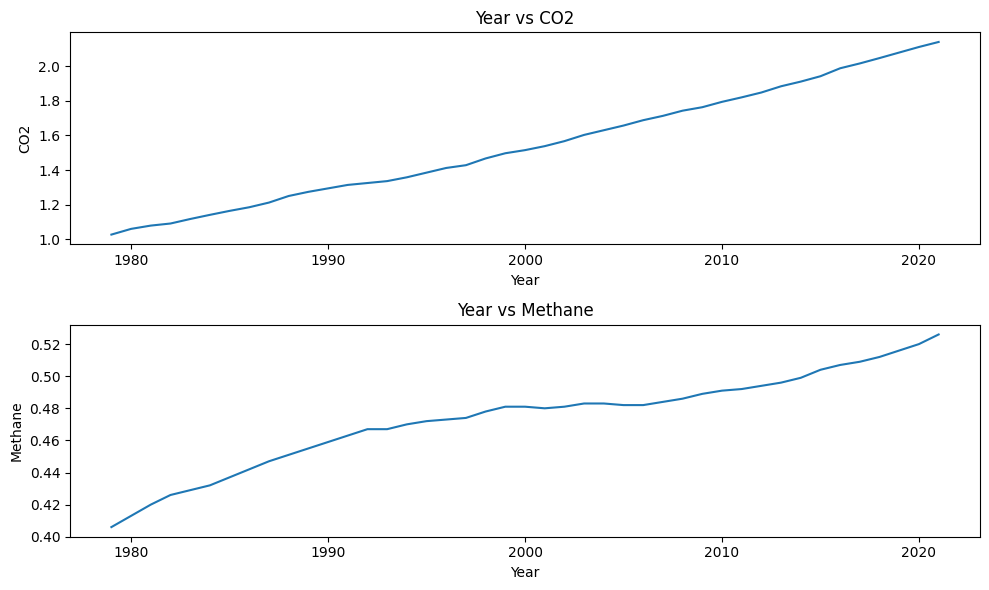

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Year vs. CO2
plt.subplot(2, 1, 1)
plt.plot(data['Year'], data['CO2'])
plt.title('Year vs CO2')
plt.xlabel('Year')
plt.ylabel('CO2')

# Year vs. Methane
plt.subplot(2, 1, 2)
plt.plot(data['Year'], data['Methane'])
plt.title('Year vs Methane')
plt.xlabel('Year')
plt.ylabel('Methane')

plt.tight_layout()
plt.show()


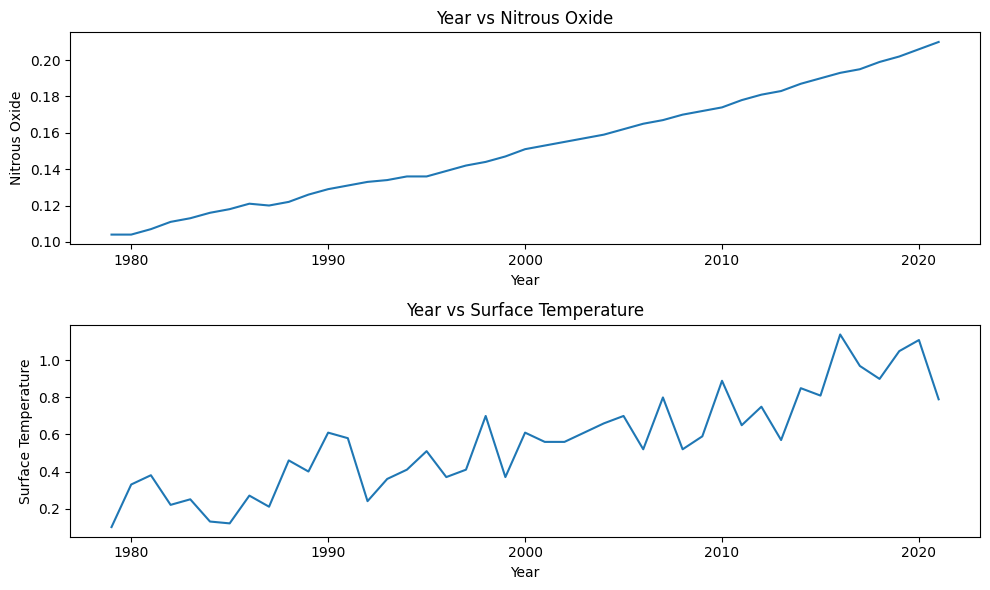

In [29]:
plt.figure(figsize=(10, 6))

# Year vs. Nitrous Oxide
plt.subplot(2, 1, 1)
plt.plot(data['Year'], data['Nitrous_Oxide'])
plt.title('Year vs Nitrous Oxide')
plt.xlabel('Year')
plt.ylabel('Nitrous Oxide')

# Year vs. Surface Temperature
plt.subplot(2, 1, 2)
plt.plot(data['Year'], data['Surface_Temperature'])
plt.title('Year vs Surface Temperature')
plt.xlabel('Year')
plt.ylabel('Surface Temperature')

plt.tight_layout()
plt.show()


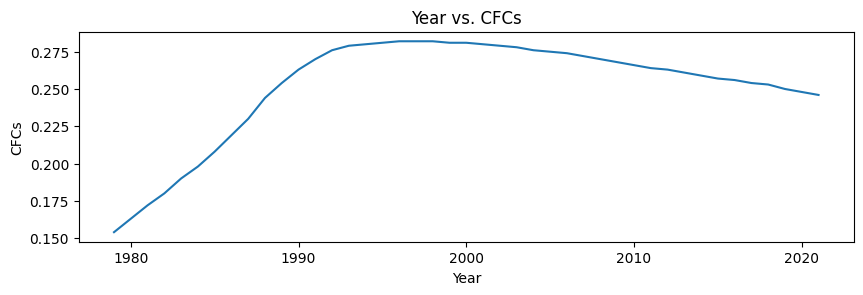

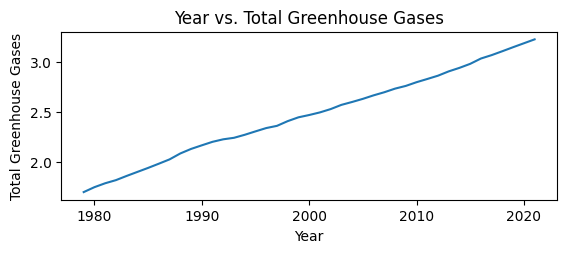

In [27]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data['Year'], data['CFCs'])
plt.title('Year vs. CFCs')
plt.xlabel('Year')
plt.ylabel('CFCs')
plt.show()
plt.subplot(2, 1, 2)
plt.plot(data['Year'], data['Total_Greenhouse_Gases'])
plt.title('Year vs. Total Greenhouse Gases')
plt.xlabel('Year')
plt.ylabel('Total Greenhouse Gases')
plt.show()


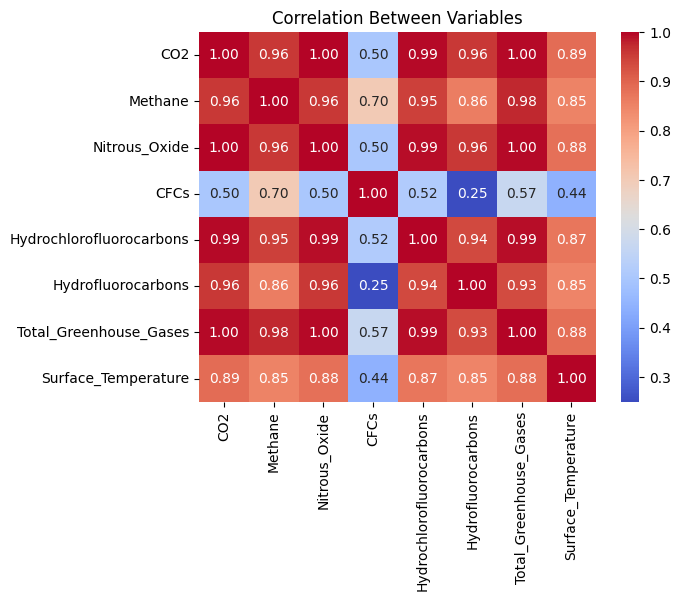

In [28]:


# Select the variables for correlation analysis
correlation_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs', 'Hydrochlorofluorocarbons', 'Hydrofluorocarbons', 'Total_Greenhouse_Gases', 'Surface_Temperature']

# Compute the correlation matrix
correlation_matrix = data[correlation_variables].corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Variables')
plt.show()


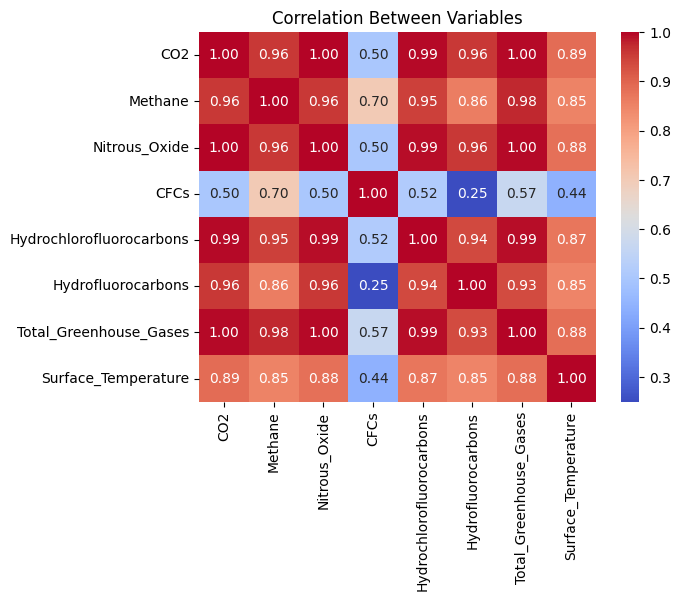

In [29]:


# Select the variables for correlation analysis
correlation_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs', 'Hydrochlorofluorocarbons', 'Hydrofluorocarbons', 'Total_Greenhouse_Gases', 'Surface_Temperature']

# Compute the correlation matrix
correlation_matrix = data[correlation_variables].corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Variables')
plt.show()


# data Modeling

In [85]:
class ModelNN:

    def __init__(self, model, data, scaler, target_variables, is_tf_model=True):
        self.model = model
        self.data = data
        self.scaler = scaler
        self.is_tf_model = is_tf_model
        self.target_variables = target_variables

    def predict(self, input_year):
        print('input_year', input_year)
        time_steps = 1
        predicted_val = []
        if input_year > 2021:
            # Prepare the input data
            input_data = self.data[self.data['Year'] <= 2021]
            input_data_scaled = self.scaler.transform(input_data[self.target_variables])
            # Prepare the input sequence
            input_sequences = []
            for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
                input_sequences.append(input_data_scaled[i - time_steps:i])

            for year in range(2022, input_year + 1):
                input_sequences_array = np.array([sequence for sequence in input_sequences if len(sequence) == time_steps])
                input_sequence_reshaped = np.reshape(input_sequences_array, (input_sequences_array.shape[0], input_sequences_array.shape[1], len(target_variables)))

                # Make predictions for the input sequence
                if self.is_tf_model:
                    predictions = self.model.predict(input_sequence_reshaped[-1].reshape(1, time_steps, len(self.target_variables)))
                else:
                    predictions = self.model.predict(input_sequence_reshaped[-1].reshape(1, time_steps, len(self.target_variables)).reshape(1, 12))

                # Inverse transform the predicted values
                prediction = self.scaler.inverse_transform(predictions)

                # Get the predicted values for the current year
                predicted_values = prediction[0]

                # Append the predicted values to the results
                predicted_val.append(predicted_values)

                # Update the input sequence for the next iteration
                input_sequences[0][:-1] = input_sequences[0][1:]  # Remove the first value
                input_sequences[0][-1] = np.array(predictions)  # Add predictions at the last index
        else:
            input_data = self.data[self.data['Year'] < input_year]
            input_data_scaled = self.scaler.transform(input_data[self.target_variables])
            # Prepare the input sequence
            input_sequence = []
            for i in range(len(input_data_scaled) - time_steps, len(input_data_scaled)):
                input_sequence.append(input_data_scaled[i - time_steps:i])

            input_sequence = np.array(input_sequence)

            # Reshape the input sequence for LSTM (input_shape: [samples, time_steps, features])
            if self.is_tf_model:
                input_sequence = np.reshape(input_sequence, (input_sequence.shape[0], input_sequence.shape[1], len(self.target_variables)))
            else:
                input_sequence = input_sequence.reshape(1, 12)

            # Make predictions for the input sequence
            predictions = self.model.predict(input_sequence)

            # Inverse transform the predicted values
            predicted_val = self.scaler.inverse_transform(predictions)
        return predicted_val[-1]

In [31]:
def convert_watt_per_m2_to_joule_per_year(watt_per_m2):
    total_surface_area_earth_m2 = 5.1 * 10**14
    seconds_per_year = 60 * 60 * 24 * 365
    joules_per_year = watt_per_m2 * total_surface_area_earth_m2 * seconds_per_year
    return joules_per_year

## data setting for Models

In [32]:


# Assuming you have your time series data stored in a pandas DataFrame named 'data' with columns: Year, CO2, Methane, Nitrous_Oxide, CFCs, ...

# Extract the variables for prediction
target_variables = ['CO2', 'Methane', 'Nitrous_Oxide', 'CFCs',
       'Hydrochlorofluorocarbons', 'Hydrofluorocarbons',
       'Total_Greenhouse_Gases', 'Total_Greenhouse_Gases_Scaled',
       '1990_Equals_1', 'Change', 'Surface_Temperature', 'CO2_Mean']

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[target_variables])

# Define the number of time steps (lags) to consider
time_steps = 1

# Prepare the training data
train_data = data_scaled[data['Year'] < 2012]
X_train = []
y_train = []
for i in range(time_steps, len(data_scaled)):
    X_train.append(data_scaled[i - time_steps:i])
    y_train.append(data_scaled[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Prepare the test data
test_data = data_scaled[data['Year'] >= 2012]
X_test = []
y_test = []
for i in range(0, len(test_data)):
    val=i+len(train_data)
    X_test.append(data_scaled[val - time_steps:val])
    y_test.append(test_data[i])

X_test = np.array(X_test)
y_test = np.array(y_test)


In [100]:
variables_to_convert = ["CO2", "Methane", "Nitrous_Oxide", "CFCs", "Hydrochlorofluorocarbons", "Hydrofluorocarbons", "Total_Greenhouse_Gases"]

In [34]:
y_test.shape,y_train.shape

((10, 12), (42, 12))

### LSTM Model

In [36]:
# Build the LSTM model
def create_lstm_model_template(optimizer, activation, neurons):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
    for layer in neurons:
        model.add(Dense(layer, activation=activation))
    model.add(Dense(len(target_variables), activation='linear'))  # Adjust the output dimension based on the number of target variables

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])
    return model

# Train the model



In [37]:
model = KerasRegressor(model=create_lstm_model_template, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = ((64, 32, 16), (32, 32), (64, 24))
optimizer = ('SGD', 'Adadelta', 'Adam', 'Adamax')
activation = ('relu', 'softmax')
param_grid = dict(model__neurons=neurons, model__optimizer=optimizer, model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [39]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.619669 using {'model__activation': 'relu', 'model__neurons': (64, 24), 'model__optimizer': 'Adam'}
-30.658506 (2.900864) with: {'model__activation': 'relu', 'model__neurons': (32, 32), 'model__optimizer': 'SGD'}
-1.324983 (0.718811) with: {'model__activation': 'relu', 'model__neurons': (32, 32), 'model__optimizer': 'Adam'}
-37.265637 (10.490074) with: {'model__activation': 'relu', 'model__neurons': (64, 24), 'model__optimizer': 'SGD'}
-0.619669 (0.826731) with: {'model__activation': 'relu', 'model__neurons': (64, 24), 'model__optimizer': 'Adam'}
-42.475893 (30.560425) with: {'model__activation': 'softmax', 'model__neurons': (32, 32), 'model__optimizer': 'SGD'}
-25.842349 (5.959455) with: {'model__activation': 'softmax', 'model__neurons': (32, 32), 'model__optimizer': 'Adam'}
-39.135149 (31.168868) with: {'model__activation': 'softmax', 'model__neurons': (64, 24), 'model__optimizer': 'SGD'}
-26.715205 (7.104081) with: {'model__activation': 'softmax', 'model__neurons': (64, 24),

In [90]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTM_Model.add(Dense(64, activation='relu'))
LSTM_Model.add(Dense(32, activation='relu'))
LSTM_Model.add(Dense(16, activation='relu'))
LSTM_Model.add(Dense(len(target_variables), activation='linear'))  # Adjust the output dimension based on the number of target variables

# Compile the model
LSTM_Model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

history=LSTM_Model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=0)

In [86]:
def create_lstm(model):
    return ModelNN(model, data, scaler, target_variables)

In [36]:
model.save('/content/drive/MyDrive/ClumateChangeData/Lstm.h5')

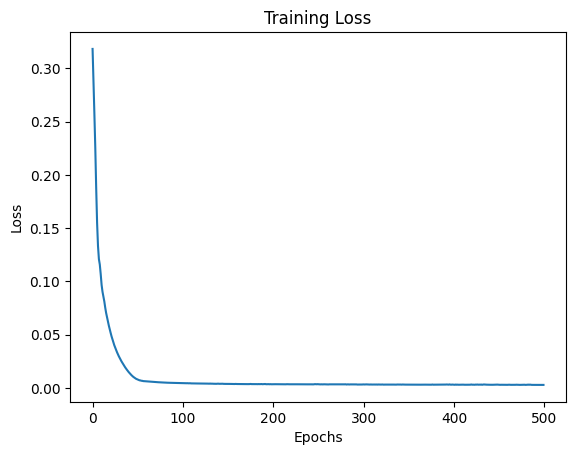

In [42]:

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [47]:
X_train.shape

(42, 1, 12)

## ANN Model

In [44]:
# Build the LSTM model
def create_ann_model_template(optimizer, activation, neurons):
    model = Sequential()
    model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
    for layer in neurons:
        model.add(Dense(layer, activation=activation))
    model.add(Dense(len(target_variables), activation='linear'))  # Adjust the output dimension based on the number of target variables

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])
    return model


In [45]:
model = KerasRegressor(model=create_ann_model_template, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = ((256, 128, 64, 32, 16), (128, 64, 32, 16), (128, 64, 128, 64))
optimizer = ('SGD', 'Adadelta', 'Adam', 'Adamax')
activation = ('relu', 'softmax')
param_grid = dict(model__neurons=neurons, model__optimizer=optimizer, model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [46]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.232350 using {'model__activation': 'relu', 'model__neurons': (128, 64, 128, 64), 'model__optimizer': 'Adamax'}
-20.438689 (4.826229) with: {'model__activation': 'relu', 'model__neurons': (256, 128, 64, 32, 16), 'model__optimizer': 'SGD'}
-79.970524 (71.822241) with: {'model__activation': 'relu', 'model__neurons': (256, 128, 64, 32, 16), 'model__optimizer': 'Adadelta'}
-3.227534 (0.824462) with: {'model__activation': 'relu', 'model__neurons': (256, 128, 64, 32, 16), 'model__optimizer': 'Adamax'}
-14.974397 (3.603453) with: {'model__activation': 'relu', 'model__neurons': (128, 64, 128, 64), 'model__optimizer': 'SGD'}
-75.084943 (67.902908) with: {'model__activation': 'relu', 'model__neurons': (128, 64, 128, 64), 'model__optimizer': 'Adadelta'}
-0.232350 (0.815555) with: {'model__activation': 'relu', 'model__neurons': (128, 64, 128, 64), 'model__optimizer': 'Adamax'}
-34.504054 (24.078771) with: {'model__activation': 'softmax', 'model__neurons': (256, 128, 64, 32, 16), 'model__op

In [47]:


# Build the ANN model
ANN_Model = Sequential()
ANN_Model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
ANN_Model.add(Dense(256, activation='relu'))
ANN_Model.add(Dense(128, activation='relu'))
ANN_Model.add(Dense(64, activation='relu'))
ANN_Model.add(Dense(32, activation='relu'))
ANN_Model.add(Dense(16, activation='relu'))
ANN_Model.add(Dense(X_train.shape[2], activation='linear'))  # Adjust the output dimension based on the number of features

# Compile the model
ANN_Model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history = ANN_Model.fit(X_train, y_train, epochs=300, batch_size=16, verbose=0)


In [87]:
def create_ann(model):
    return ModelNN(model, data, scaler, target_variables)

In [54]:
ANN_Model.save('/content/drive/MyDrive/ClumateChangeData/ann_model.h5')

### Polynomial Regression

In [80]:
def polynomial_regression(x_coordinates, y_coordinates, degree=2):
    # Fit a polynomial of the specified degree to the data
    coefficients = np.polyfit(x_coordinates, y_coordinates, degree)

    return coefficients

In [81]:
yValues = []
for index in range(1, len(df_list)):
    yValues.append(df_list[index][0])
yValues = np.array(yValues)  # Convert yValues to a numpy array
all_coeff = []

for index1 in range(1, len(df_list[0])):
    xValues = []
    prediction = 0
    #finds all of the known x-values
    for index2 in range(1, len(df_list)):
        xValues.append(df_list[index2][index1])
    xValues = np.array(xValues)  # Convert xValues to a numpy array
    line = polynomial_regression(yValues, xValues,3)
    all_coeff.append(line)

In [82]:
all_coeff

[array([ 2.20197487e-06, -1.30514452e-02,  2.58076263e+01, -1.70237508e+04]),
 array([ 3.78616618e-06, -2.27477814e-02,  4.55583439e+01, -3.04144134e+04]),
 array([ 4.88559670e-07, -2.91585537e-03,  5.80301454e+00, -3.85093521e+03]),
 array([ 6.00364791e-06, -3.62207589e-02,  7.28391510e+01, -4.88241675e+04]),
 array([-8.06294716e-07,  4.84005557e-03, -9.68313692e+00,  6.45644188e+03]),
 array([ 2.69470706e-07, -1.58410870e-03,  3.10368526e+00, -2.02669299e+03]),
 array([ 1.19832571e-05, -7.19194440e-02,  1.43910079e+02, -9.60059679e+04]),
 array([ 1.01772366e-03, -6.09730090e+00,  1.21790973e+04, -8.11033931e+06]),
 array([ 5.57493602e-06, -3.34585811e-02,  6.69495743e+01, -4.46631715e+04]),
 array([ 1.06272132e-05, -6.26086194e-02,  1.22902511e+02, -8.03867556e+04]),
 array([ 6.47115814e-06, -3.86665694e-02,  7.70293628e+01, -5.11611786e+04]),
 array([ 2.42828168e-04, -1.44096957e+00,  2.85172799e+03, -1.88183292e+06])]

In [51]:
class LSRM:
    def __init__(self, coeff: np.ndarray, degree: int = 3):
        self.coeff = coeff
        self.degree = degree
    
    # def train()

    def predict(self, year: int):
        all_predictions = []
        for c in range(12):
            prediction = 0
            coeff = self.coeff[c]
            for index2 in range(self.degree+1):
                prediction+=coeff[len(coeff)-index2-1]*float(year)**index2
            all_predictions.append(prediction)
        return all_predictions

In [52]:
def create_lsrm(coeff: np.ndarray):
    return LSRM(coeff)

### Random Forest model

In [ ]:
X_train = X_train.reshape((32, 12))

In [ ]:
model_rfr = RandomForestRegressor(n_estimators=10)
model_rfr.fit(X_train, y_train)

In [ ]:
model_rfr.score(X_test.reshape((12, 12)), y_test)

In [ ]:
y_train_predict = model_rfr.predict(X_train)
y_test_predict = model_rfr.predict(X_test.reshape((12, 12)))

In [ ]:
fig, axes = plt.subplots(1, 1)
x = [ii for ii in range(y_train_predict.shape[0])]
axes.plot(x, y_train_predict[:, 0], label='Predict')
axes.plot(x, y_train[:, 0], label='Actual')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.legend()

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1)
x = [ii for ii in range(y_test_predict.shape[0])]
axes.plot(x, y_test_predict[:, 0], label='Predict')
axes.plot(x, y_test[:, 0], label='Actual')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.legend()

plt.show()

### ARIMA model

In [53]:
train_data = data_scaled[data['Year'] < 2012]
test_data = data_scaled[data['Year'] >= 2012]
train_df = pd.DataFrame(train_data, columns=target_variables)
train_df['Year'] = data.loc[data['Year'] < 2012]['Year']
train_df.index = train_df['Year']

In [54]:


def evaluate_arima_model(dataset, arima_order):
    train_size = 33
    train, test = dataset[0:train_size], dataset[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [55]:
def evaluate_models(dataset, p_values, d_values, q_values):
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					# print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	return best_cfg

In [56]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
# CO2 - ARIMA(4, 1, 2)
# Methane - ARIMA(0, 2, 2)
# Nitrous_Oxide - ARIMA(6, 1, 2)
# CFCs - ARIMA(10, 1, 0)
for var_index in range(len(target_variables)):
    dataset_arima = data[target_variables[var_index]].values[:]
    warnings.filterwarnings("ignore")
    best_cfg = evaluate_models(dataset_arima, p_values, d_values, q_values)
    print("{} - {}".format(target_variables[var_index], best_cfg))

CO2 - (2, 2, 0)
Methane - (2, 2, 0)
Nitrous_Oxide - (6, 2, 1)
CFCs - (4, 1, 2)
Hydrochlorofluorocarbons - (1, 1, 0)
Hydrofluorocarbons - (2, 2, 2)
Total_Greenhouse_Gases - (2, 2, 0)
Total_Greenhouse_Gases_Scaled - (8, 0, 2)
1990_Equals_1 - (2, 2, 0)
Change - (8, 0, 1)
Surface_Temperature - (1, 2, 2)
CO2_Mean - (2, 2, 0)


In [98]:
class ModelARIMA:
    def __init__(self, data, start_year=1979, train_year=2012):
        self.data = data
        self.start_year = start_year
        self.train_year = train_year

    def predict(self, end_year):
        train_data = self.data.loc[self.data['Year']<self.train_year]
        predictions = []
        start = self.start_year - 1979 
        end = end_year - 1979
        arima_order_dict = {
            "CO2": (4, 1, 2),
            "Methane": (0, 2, 2),
            "Nitrous_Oxide": (6, 1, 2),
            "CFCs": (10, 1, 0),
            "Hydrochlorofluorocarbons": (1, 1, 1),
            "Hydrofluorocarbons":  (4, 2, 1),
            "Total_Greenhouse_Gases": (1, 1, 1), #(10, 0, 1),
            "Total_Greenhouse_Gases_Scaled": (1, 1, 1), #(4, 0, 1),
            "1990_Equals_1":  (1, 1, 1),#(6, 0, 1),
            "Change": (8, 0, 1),
            "Surface_Temperature": (1, 1, 0),
            "CO2_Mean": (1, 1, 1)
        }
        for target in target_variables:
            model = ARIMA(train_data[target], order=arima_order_dict[target])
            model_fit = model.fit()
            y_predict = model_fit.predict(strat=start, end=end)[end]
            predictions.append(y_predict)
        return predictions


In [96]:
def create_arima():
    return ModelARIMA(data)

### MLP Regressor

In [60]:
model_regr = MLPRegressor(max_iter=500)

In [61]:
parameters = {
    'solver': ('lbfgs', 'adam'),
    'activation': ('logistic', 'tanh', 'relu'),
    'hidden_layer_sizes': ((5,), (5,3), (5,5), (5,6), (5,8), (6,5), (7,5))
    }

grid = GridSearchCV(model_regr, param_grid=parameters,scoring='accuracy', cv=10)


In [64]:
grid_result = grid.fit(X_train.reshape(42, 12), y_train)

In [67]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: nan using {'activation': 'logistic', 'hidden_layer_sizes': (5,), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5,), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5,), 'solver': 'adam'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 3), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 3), 'solver': 'adam'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 5), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 5), 'solver': 'adam'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 6), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 6), 'solver': 'adam'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 8), 'solver': 'lbfgs'}
nan (nan) with: {'activation': 'logistic', 'hidden_layer_sizes': (5, 8), 'solver': 'adam'}

In [69]:
model_regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', hidden_layer_sizes=(5, 6)).fit(X_train.reshape(42, 12), y_train)

In [88]:
def create_mlp_regressor(model):
    return ModelNN(model, data, scaler, target_variables, is_tf_model=False)

# Plot predictions

In [99]:
start_year = 2000
end_year = 2051
lsrm_predictions = []
lstm_predictions = []
ann_predictions = []
arima_predictions = []
mlp_regressor_predictions = []

model_ann = create_ann(ANN_Model)
model_lstm = create_lstm(LSTM_Model)
model_lsrm = create_lsrm(all_coeff)
model_arima = create_arima()
model_mlp_regressor = create_mlp_regressor(model_regr)

for year in range(start_year, end_year):
    lsrm_predictions.append(model_lsrm.predict(year))
    lstm_predictions.append(model_lstm.predict(year))
    ann_predictions.append(model_ann.predict(year))
    arima_predictions.append(model_arima.predict(year))
    mlp_regressor_predictions.append(model_mlp_regressor.predict(year))

input_year 2000
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step
input_year 2000
1/1 [==============================] - 0s 12ms/step
input_year 2000
input_year 2001
1/1 [==============================] - 0s 15ms/step
input_year 2001
1/1 [==============================] - 0s 19ms/step
input_year 2001
input_year 2002
1/1 [==============================] - 0s 25ms/step
input_year 2002
1/1 [==============================] - 0s 28ms/step
input_year 2002
input_year 2003
1/1 [==============================] - 0s 12ms/step
input_year 2003
1/1 [==============================] - 0s 19ms/step
input_year 2003
input_year 2004
1/1 [==============================] - 0s 15ms/step
input_year 2004
1/1 [==============================] - 0s 17ms/step
input_year 2004
input_year 2005
1/1 [==============================] - 0s 16ms/step
input_year 2005
1/1 [==============================] - 0s 12ms/step
input_year 2005
input_year 2006
1/1 [==============================] - 0s 12ms/step
input_year 2006
1/1 [===============

In [101]:
df_lsrm = pd.DataFrame(lsrm_predictions, columns=target_variables)
df_lstm = pd.DataFrame(lstm_predictions, columns=target_variables)
df_ann = pd.DataFrame(ann_predictions, columns=target_variables)
df_arima = pd.DataFrame(arima_predictions, columns=target_variables)
df_mlp_regressor = pd.DataFrame(mlp_regressor_predictions, columns=target_variables)


df_lsrm[variables_to_convert] = df_lsrm[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_lstm[variables_to_convert] = df_lstm[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_ann[variables_to_convert] = df_ann[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_arima[variables_to_convert] = df_arima[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
df_mlp_regressor[variables_to_convert] = df_mlp_regressor[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)


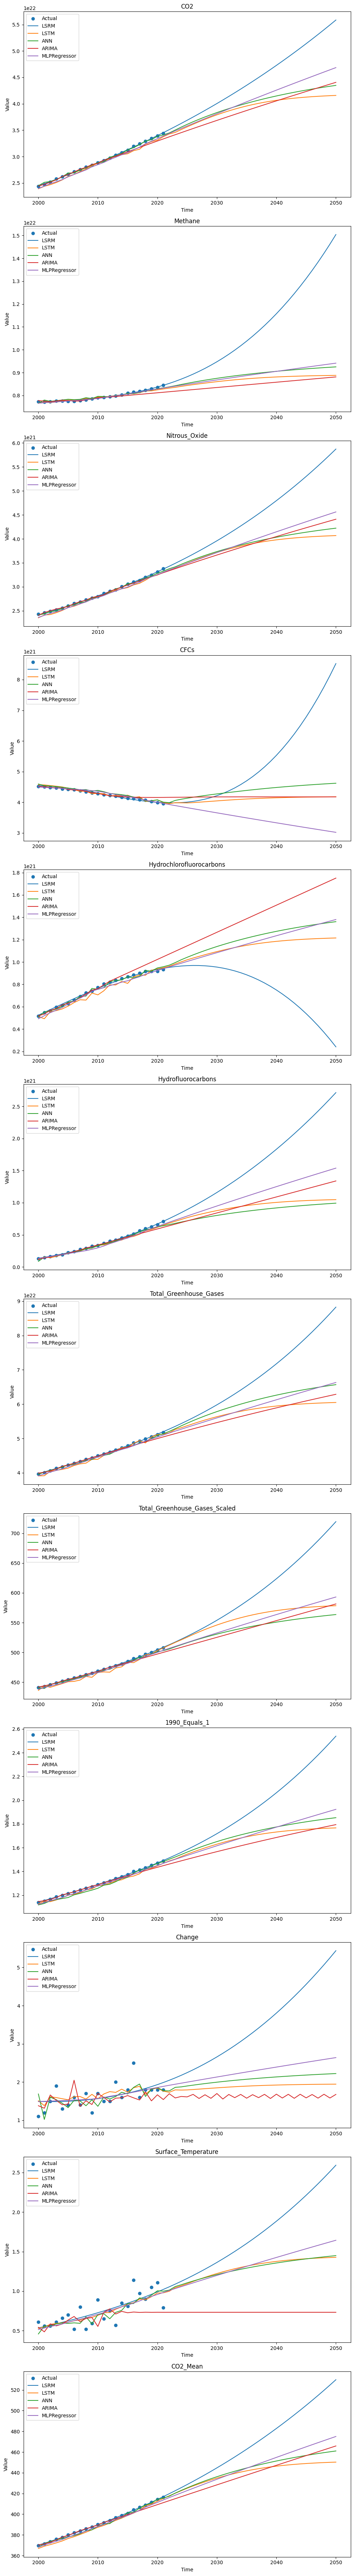

In [102]:
# Plot actual vs predicted for each target variable
fig, axes = plt.subplots(len(target_variables), 1, figsize=(10, 6 * len(target_variables)))
years = [year for year in range(start_year, end_year)]
data_to_print = data.loc[data['Year']>=start_year]
data_to_print[variables_to_convert] = data_to_print[variables_to_convert].applymap(convert_watt_per_m2_to_joule_per_year)
for i, target_variable in enumerate(target_variables):
    axes[i].scatter(data_to_print['Year'], data_to_print[target_variable], label='Actual', marker='o')
    axes[i].plot(years, df_lsrm[target_variable], label='LSRM')
    axes[i].plot(years, df_lstm[target_variable], label='LSTM')
    axes[i].plot(years, df_ann[target_variable], label='ANN')
    axes[i].plot(years, df_arima[target_variable], label='ARIMA')
    axes[i].plot(years, df_mlp_regressor[target_variable], label='MLPRegressor')
    axes[i].set_title(target_variable)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].legend()

plt.tight_layout()
plt.show()